Author: Andreas Traut   
Basis for this notebook are various tutorials which I found on the internet and documentation from Tensorflow.   
Date: 11.09.2020

In this notebook the data will be loaded, the model will be designed, optimized, trained, evaluated and saved. 

# Import the libaries

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import constraints 
from tensorflow.keras import utils

In [2]:
seed = 21

# Load and prepare the data

In [3]:
dataset_path = "C:\\Users\\andre\\Documents\\GitHub\\Deep_learning_explorations\\data\\caltechown"

In [4]:
data_dir = pathlib.Path(dataset_path)
data_dir

WindowsPath('C:/Users/andre/Documents/GitHub/Deep_learning_explorations/data/caltechown')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

9266


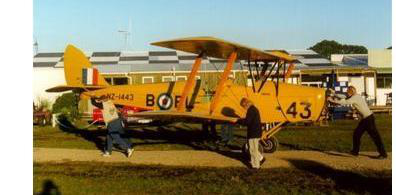

In [6]:
pic = list(data_dir.glob('001/*'))
PIL.Image.open(str(pic[0]))

In [7]:
pic[0]

WindowsPath('C:/Users/andre/Documents/GitHub/Deep_learning_explorations/data/caltechown/001/100.jpg')

In [8]:
img_width, img_height =tf.keras.preprocessing.image.load_img(pic[0]).size

In [9]:
batch_size = 32

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  labels="inferred", 
  label_mode="categorical",  
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9267 files belonging to 107 classes.
Using 7414 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  labels="inferred", 
  label_mode="categorical",  
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9267 files belonging to 107 classes.
Using 1853 files for validation.


In [12]:
class_num = 107

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Design the model

In [15]:
model = Sequential()

The first layer is a convolutional layer. We specify 32 filters (size of each filter is 3x3). 

Activation is "relu". 

Dont change the size of the image: Padding='same' 

In [16]:
model.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 3), padding='same'))
model.add(Activation('relu'))

In order to prevent overfitting we randomly put 20% or the connections to zero: 

In [17]:
model.add(Dropout(0.2))

Batch Normalization normalizes the inputs heading into the next layer, ensuring that the network always creates activations with the same distribution that we desire:

In [18]:
model.add(BatchNormalization())

Now comes another convolutional layer, but the filter size increases so the network can learn more complex representations:

In [19]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

Pooling layer: helps make the image classifier more robust. It's important not to have too many pooling layers, as each pooling discards some data. Pooling too often will lead to there being almost nothing for the densely connected layers to learn about when the data reaches them.

Plus dropout and BatchNormalization. 

In [20]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Now repeat this: 

In [21]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Now we need to Flatten the data:


In [22]:
model.add(Flatten())
model.add(Dropout(0.2))

Now create densely connected layer. 
The kernel constraint can regularize the data as it learns, another thing that helps prevent overfitting.

In [23]:
model.add(Dense(256, kernel_constraint=constraints.MaxNorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(128, kernel_constraint=constraints.MaxNorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Finally, the softmax activation function selects the neuron with the highest probability as its output, voting that the image belongs to that class:

In [24]:
model.add(Dense(class_num))
model.add(Activation('softmax'))
#model.add(Activation('sigmoid'))

# Optimize the model

Now that we've designed the model we want to use, we just have to compile it. Let's specify the number of epochs we want to train for, as well as the optimizer we want to use.

In [25]:
epochs = 5
optimizer = 'adam'
#optimizer = optimizers.Adam(learning_rate=0.01)  if another learning rate should be taken

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.optimizer.lr

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 396, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 195, 396, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 195, 396, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 195, 396, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 195, 396, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 195, 396, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 198, 64)       0

# Train the model and use Tensorboard

In [29]:
np.random.seed(seed)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size) #, callbacks=[tensorboard_callback])

Epoch 1/5
232/232 [==============================] - 1765s 8s/step - loss: 3.8833 - accuracy: 0.2325 - val_loss: 3.0837 - val_accuracy: 0.3589
Epoch 2/5
232/232 [==============================] - 1809s 8s/step - loss: 2.7489 - accuracy: 0.4043 - val_loss: 2.9007 - val_accuracy: 0.3799
Epoch 3/5
232/232 [==============================] - 1847s 8s/step - loss: 2.4930 - accuracy: 0.4473 - val_loss: 2.4067 - val_accuracy: 0.4571
Epoch 4/5
232/232 [==============================] - 1761s 8s/step - loss: 2.3214 - accuracy: 0.4690 - val_loss: 2.2500 - val_accuracy: 0.4781
Epoch 5/5
232/232 [==============================] - 1713s 7s/step - loss: 2.2060 - accuracy: 0.4869 - val_loss: 2.2582 - val_accuracy: 0.4749


To plot the learning curve:

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

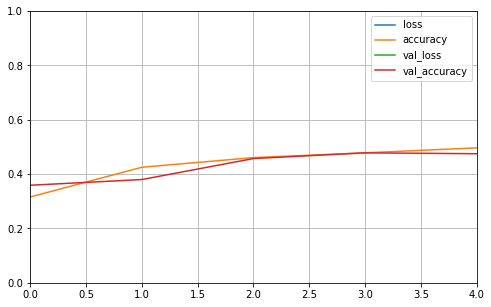

In [31]:
plot_learning_curves(history)

In [36]:
history.history

{'loss': [3.402697801589966,
  2.6276707649230957,
  2.413815975189209,
  2.2635107040405273,
  2.1554038524627686],
 'accuracy': [0.3157539665699005,
  0.4251416325569153,
  0.46061503887176514,
  0.4781494438648224,
  0.4964931309223175],
 'val_loss': [3.083719491958618,
  2.90073299407959,
  2.4066503047943115,
  2.2500343322753906,
  2.2581887245178223],
 'val_accuracy': [0.3588775098323822,
  0.3799244463443756,
  0.4570966064929962,
  0.4781435430049896,
  0.4749055504798889]}

# Evaluate model

In [32]:
scores = model.evaluate(val_ds, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 47.49%


# Save Model

In [33]:
model.save('saved_model/my_model_caltechown') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model_caltechown\assets
